# Modelo para producción

## Importación de librerías

Importamos la librerías necesarias.

In [214]:
## Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Para el cálculo de distancias entre apartamentos y medios de transporte
from geopy.distance import distance
from decimal import *
## Librerías para el entrenamiento del modelo
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor 
from scipy.stats import zscore

## Import Data
Cargamos el Data Set con el que entrenaremos el modelo.

In [215]:
output_file_path = '../data/listings.csv'
df = pd.read_csv(output_file_path, low_memory=False)

## Preparación del _Data Set_ de entrenamiento

### Limpieza inicial de los datos

Eliminamos todas aquellos datos que no encontraremos en el _Data Set_ de Idealista.

También eliminaremos aquellos datos que no estén relacionados con el precio de los apartamentos.

In [216]:
df = df.drop(columns=['id','listing_url', 
                      'neighbourhood_cleansed','minimum_nights','maximum_nights',
                      'estimated_occupancy_l365d','estimated_revenue_l365d','scrape_id',
                      'last_scraped','source','neighborhood_overview',
                      'host_id','host_url','host_name',
                      'host_since','host_location','host_response_time',
                      'host_response_rate','host_acceptance_rate','host_is_superhost',
                      'host_thumbnail_url','host_picture_url','host_listings_count',
                      'host_total_listings_count','host_verifications','host_has_profile_pic',
                      'host_identity_verified','neighbourhood','bathrooms_text',
                      'beds','minimum_minimum_nights','maximum_minimum_nights',
                      'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                      'maximum_nights_avg_ntm','has_availability','calendar_last_scraped',
                      'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d',
                      'availability_eoy','number_of_reviews_ly','first_review',
                      'last_review','review_scores_rating','review_scores_accuracy',
                      'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                      'review_scores_location','review_scores_value','license',
                      'instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month',
                      'host_about','host_neighbourhood','calendar_updated',
                      'availability_30','availability_60','availability_90',
                      'availability_365','picture_url','accommodates'])

Eliminamos las habitaciones, casas compartidas, hoteles, etc. ya que solo queremos VIVIENDAS COMPLETAS.

In [217]:
df = df[df['room_type']== 'Entire home/apt'].copy()

También utilizamos los datos de "_room_type_" para borrar aquellos datos que no sean viviendas que hagan referencia a cámpers, apartahoreles o bungalows.

In [218]:
property_types_to_remove = ['Camper/RV', 'Room in aparthotel', 'Entire cabin','Hut','Yurt','Entire Bungalow']
df = df[~df['property_type'].isin(property_types_to_remove)].copy()

También eliminaremos los anuncios que se encuentren duplicados. Para ello, compararemos los datos de 2 parámetros, "_name_" y "_description_", para encontrar aquellos anuncios donde este campo se encuentre duplicado, en cuyo caso, borraremos dichos anuncios menos 1.

In [219]:
df["name_description"] = df["name"].fillna(" ").str.lower() + " and " + df["description"].fillna(" ").str.lower()
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

name_description
flamenco style apartment | palacio real, la latina and wonderful apartment located just above one of the oldest flamenco tablao in madrid, the corral de la morería, recently renovated opting for quality and comfort, offering an incredible rest. located in one of the most central areas of madrid that offers a multitude of restaurants, leisure and culture a few steps from the nerve center of the city. it has a bedroom with a queen size bed, a sofa bed, complete kitchen and a bathroom. whether for leisure or work, enjoy your apartment!    14
home art madrid estudio estándar and this studio apartment has impeccable interior design. its modern style makes it one of the most practical. everything is paid to attention to every last detail. due to its unbeatable location and interior care, it is perfect to enjoy one of the most sought-after areas in madrid.                                                                                                                          

In [220]:
df.drop_duplicates(subset=["name_description"], keep="first", inplace=True)

Además, dado que nuestro valor _target_ será el precio por noche, eliminaremos todos aquellos apartamentos que no tengan precio.

In [221]:
df.dropna(subset=['price'], how='any', inplace=True)

### Preprocesamiento de datos iniciales

Por un lado, completamos los valores desconocidos con 0 en los campos referentes a los baños y las habitaciones, y los convertimos a tipo de dato "_int_". Además, entendemos que en todos aquellos apartamentos que tengan 0 habitaciones y 0 baños, realmente cuenta con un mínimo de 1 en cada caso, por lo que sustituimos dichos 0 por 1.

Por otro lado, convertimos los datos de precios por noche en tipo "_float_".

In [222]:
df['bathrooms'] = df['bathrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['bedrooms'] = df['bedrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)

df['bathrooms'] = df['bathrooms'].replace(0,1)
df['bedrooms'] = df['bedrooms'].replace(0,1)

df['price'] = df['price'].replace({'\\$': '', ',': ''}, regex=True).astype(float)

#### Comodidades o servicios (_amenities_)

De los datos de "_amenities_", extraemos aquellos datos con los que contamos dentro del DS de Idealista:
- Calefacción
- Piscina
- Áire acondicionado
- Ascensor
- Movilidad reducida

In [223]:
df['calefaccion'] = df['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)
df['piscina'] = df['amenities'].apply(lambda x: 1 if ('pool' in str.lower(x)) and ('whirlpool' not in str.lower(x)) and ('whirpool' not in str.lower(x)) else 0)
df['aire_acondicionado'] = df['amenities'].apply(lambda x: 1 if 'air conditi' in str.lower(x) else 0)
df['ascensor'] = df['amenities'].apply(lambda x: 1 if 'elevator' in str.lower(x) else 0)
df['movilidad_reducida'] = df['amenities'].apply(lambda x: 1 if 'single level home' in str.lower(x) else 0)

No tiene sentido que el apartamento cuente con instalaciones para mobilidad reducida pero que no cuente con ascensor. Esto solo tendría sentido si el apartamento se encontrara en una planta baja.

Es por ello que hemos decidido eliminar todos aquellos apartamentos con instalaciones para personas con movilidad reducida pero que no cuenten con ascensor.

In [224]:
df = df[(df["movilidad_reducida"] == 1) & (df["ascensor"] == 1) | (df["movilidad_reducida"] == 0)]

#### Descripción del apartamento (_name_description_)

De la columna creada anteriormente "_name_description_", se pueden obtener más datos en cuanto a terrazas y balcones.

In [225]:
df["terraza"] = df["name_description"].apply(lambda x: 1 if "terrace" in x else 0)
df["balcon"] = df["name_description"].apply(lambda x: 1 if "balcon" in x else 0)

### Creación de nuevas variables

Para enriquecer nuestro modelo, una de las mejores formas de hacerlo es obtener nuevas variables que puedan dar más información.

#### Distancia a puntos estratégicos de Madrid

Entendemos que unos de los mayores atractivos de los apartamentos turísitcos es la ubicación en la que se encuentran. Es por ello que hemos calculado la distancia de cada uno de los apartamentos a 4 puntos diferentes de Madrid que entendemos que son de mayor interés a la hora de buscar un apartamento turísitico:
- Centro de Madrid (Puerta del Sol)
- Parque de El Retiro
- Estación de Atocha
- Estación de Chamartín

In [226]:
# Create distance to city center
center_lat, center_lon = 40.4168, -3.7038
df['distance_to_center'] = np.sqrt((df['latitude'] - center_lat)**2 + (df['longitude'] - center_lon)**2)

# Create distance to El Retiro
retiro_lat, retiro_lon = 40.415262, -3.6883366
df['distance_to_retiro'] = np.sqrt((df['latitude'] - retiro_lat)**2 + (df['longitude'] - retiro_lon)**2)

# Create distance to Atocha
atocha_lat, atocha_lon = 40.405383, -3.6914676
df['distance_to_atocha'] = np.sqrt((df['latitude'] - atocha_lat)**2 + (df['longitude'] - atocha_lon)**2)

# Create distance to Chamartín
chamartin_lat, chamartin_lon = 40.472103, -3.6852973
df['distance_to_chamartin'] = np.sqrt((df['latitude'] - chamartin_lat)**2 + (df['longitude'] - chamartin_lon)**2)

#### Data Import of Rentas Ayto Madrid

Se han obtenido datos de las rentas que hay en cada distrito:
- Renta neta media por persona
- Renta neta media por hogar
- Media de la renta neta por unidad de consumo
- Mediana de la renta netat por unidad de consumo
- Renta bruta media por persona
- Renta media bruta por hogar

In [227]:
df_rentas = pd.read_csv('../data/Datos_Rentas_Madrid_2022.csv',delimiter=";")
df_rentas.head()

Distrito  Renta neta media por persona  Renta neta media por hogar  \
0      01. Centro                        20.587                      41.059   
1  02. Arganzuela                        21.383                      49.236   
2      03. Retiro                        25.407                      60.762   
3   04. Salamanca                        28.140                      64.925   
4   05. Chamartín                        30.506                      74.842   

   Media de la renta neta por unidad de consumo  \
0                                        28.500   
1                                        31.038   
2                                        37.916   
3                                        42.592   
4                                        47.564   

   Mediana de la renta neta por unidad de consumo  \
0                                           22.05   
1                                           28.35   
2                                           31.85   
3                                           31.15   
4                                           34.65   

   Renta bruta media por persona  Renta media bruta por hogar  
0                         27.030                       53.908  
1                         27.431                       63.160  
2                         33.396                       79.868  
3                         38.751                       89.407  
4                         42.678                      104.706

Las rentas aparecen divididas entre 1000 en el DS obtenido.

In [228]:
for col in df_rentas.select_dtypes(include='float'):
    df_rentas[col] = df_rentas[col].apply(lambda x: x * 1000)

df_rentas.head()

Distrito  Renta neta media por persona  Renta neta media por hogar  \
0      01. Centro                       20587.0                     41059.0   
1  02. Arganzuela                       21383.0                     49236.0   
2      03. Retiro                       25407.0                     60762.0   
3   04. Salamanca                       28140.0                     64925.0   
4   05. Chamartín                       30506.0                     74842.0   

   Media de la renta neta por unidad de consumo  \
0                                       28500.0   
1                                       31038.0   
2                                       37916.0   
3                                       42592.0   
4                                       47564.0   

   Mediana de la renta neta por unidad de consumo  \
0                                         22050.0   
1                                         28350.0   
2                                         31850.0   
3                                         31150.0   
4                                         34650.0   

   Renta bruta media por persona  Renta media bruta por hogar  
0                        27030.0                      53908.0  
1                        27431.0                      63160.0  
2                        33396.0                      79868.0  
3                        38751.0                      89407.0  
4                        42678.0                     104706.0

A continuación, unificamos los nombres de los distritos de ambos DS, de forma que en el de las rentas aparezcan los mimos nombres que en el DS de AirBnB.

In [229]:
df_rentas['Distrito'] = df_rentas['Distrito'].str[4:]
df_rentas['Distrito'] = df_rentas['Distrito'].apply(lambda x: x.replace('-', ' - ') if '-' in x else x)
df_rentas.head(21)

Distrito  Renta neta media por persona  \
0                  Centro                       20587.0   
1              Arganzuela                       21383.0   
2                  Retiro                       25407.0   
3               Salamanca                       28140.0   
4               Chamartín                       30506.0   
5                  Tetuán                       18062.0   
6                Chamberí                       27076.0   
7   Fuencarral - El Pardo                       21947.0   
8       Moncloa - Aravaca                       26694.0   
9                  Latina                       14375.0   
10            Carabanchel                       12764.0   
11                  Usera                       11430.0   
12     Puente de Vallecas                       11452.0   
13              Moratalaz                       16437.0   
14          Ciudad Lineal                       17808.0   
15              Hortaleza                       21766.0   
16             Villaverde                       11563.0   
17      Villa de Vallecas                       14274.0   
18              Vicálvaro                       14832.0   
19  San Blas - Canillejas                       15902.0   
20                Barajas                       20788.0   

    Renta neta media por hogar  Media de la renta neta por unidad de consumo  \
0                      41059.0                                       28500.0   
1                      49236.0                                       31038.0   
2                      60762.0                                       37916.0   
3                      64925.0                                       42592.0   
4                      74842.0                                       47564.0   
5                      42465.0                                       25955.0   
6                      60032.0                                       40145.0   
7                      58214.0                                       34241.0   
8                      68238.0                                       41666.0   
9                      35669.0                                       20833.0   
10                     33786.0                                       18831.0   
11                     31996.0                                       17143.0   
12                     30339.0                                       16852.0   
13                     40325.0                                       23900.0   
14                     43738.0                                       26175.0   
15                     57506.0                                       34164.0   
16                     32527.0                                       17366.0   
17                     36998.0                                       21433.0   
18                     39505.0                                       22364.0   
19                     41474.0                                       23785.0   
20                     54343.0                                       31942.0   

    Mediana de la renta neta por unidad de consumo  \
0                                          22050.0   
1                                          28350.0   
2                                          31850.0   
3                                          31150.0   
4                                          34650.0   
5                                          20650.0   
6                                          31150.0   
7                                          28350.0   
8                                          30450.0   
9                                          18550.0   
10                                         16450.0   
11                                         15050.0   
12                                         15050.0   
13                                         21350.0   
14                                         21350.0   
15                                         26950.0   
16                                     

Para enriquecer los datos de AirBnB con las rentas de Madrid, extraeremos los datos de "_Renta neta media por hogar_" y crearemos una nueva columna "_renta_bin_".

En dicha columna se han segmentado y ordenado los datos de "_Renta neta media por hogar_" de cada uno de los distrito en 5 etiquetas diferentes de mayor a menor renta.

In [230]:
df_rentas['renta_bin'] = pd.cut(
    df_rentas['Renta neta media por hogar'].sort_values(),
    bins=5,
    labels=['muy_bajo','bajo','medio','alto','muy_alto'],
    include_lowest=True
)
df_rentas[['Distrito', 'Renta neta media por hogar', 'renta_bin']]

def get_renta_bin(distrito:str):
    # Busca el distrito en df_rentas y devuelve el valor de 'renta_bin'
    row = df_rentas[df_rentas['Distrito'] == distrito]
    if not row.empty:
        return row['renta_bin'].values[0]
    else:
        return None

In [231]:
df["renta_bin"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_renta_bin(x))

#### Cálculo de distancia Ubicación Alojamiento - Medios de Transportes de Madrid

Hemos obtenido un DS donde aparecen las paradas de diferentes medios de transporte a los que se puede acceder en la ciudad de Madrid.

De dicho DS lo que queremos obtener es la distancia de los diferentes apartamentos las paradas más cercanas de cada uno de estos medios de transporte:
- Metro
- Cercanías
- Interurbanos
- Empresa Municipal de Transportes de Madrid(EMT)
- Metro Ligero Oeste (MLO)

In [232]:
stops = pd.read_csv('../data/TRANSPORTS.csv')

In [233]:
TIPOS_TRANSPORTE = [4,5,6,8,10] #El 9 está integrado en el 8

In [234]:
def calcular_distancias_vivienda(row_viv):
    resultados = {}
    
    for modo in TIPOS_TRANSPORTE:
        paradas_tipo = stops[stops['mode'] == modo]

        if paradas_tipo.empty:
            resultados[f'distancia_mode_{modo}'] = None
            continue

        # filtrar primero por lat/lon cercanas para acelerar

        delta = 0.01
        paradas_candidatas = paradas_tipo[
            (abs(paradas_tipo['lat'] - row_viv['latitude']) < delta) &
            (abs(paradas_tipo['lon'] - row_viv['longitude']) < delta)
        ]




        """ Para mejorar el rendimiento voy iterando incrementando el delta a comprobar, tengo que 
        asegurarme de que haya al menos una parada en el dataset porque sino morimos en el while"""
        while paradas_candidatas.empty:  
            delta += 0.01
            print(f"Buscando paradas cercanas al modo {modo} con delta {delta}")
            paradas_candidatas = paradas_tipo[
                (abs(paradas_tipo['lat'] - row_viv['latitude']) < delta) &
                (abs(paradas_tipo['lon'] - row_viv['longitude']) < delta)
            ]
      

        # if paradas_candidatas.empty:
        #     paradas_candidatas = paradas_tipo  # fallback a todas

        distancias = paradas_candidatas.apply(
            lambda stop: distance(
                (row_viv['latitude'], row_viv['longitude']),
                (stop['lat'], stop['lon'])
            ).meters,
            axis=1
        )

        resultados[f'distancia_mode_{modo}'] = distancias.min()

    return pd.Series(resultados)

In [235]:
new_bnb_dataset = df.apply(calcular_distancias_vivienda, axis=1)
df = pd.concat([df, new_bnb_dataset], axis=1)
df

Buscando paradas cercanas al modo 10 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.03
Buscando paradas cercanas al modo 10 con delta 0.04
Buscando paradas cercanas al modo 10 con delta 0.05
Buscando paradas cercanas al modo 10 con delta 0.060000000000000005
Buscando paradas cercanas al modo 8 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.03
Buscando paradas cercanas al modo 10 con delta 0.04
Buscando paradas cercanas al modo 10 con delta 0.05
Buscando paradas cercanas al modo 10 con delta 0.060000000000000005
Buscando paradas cercanas al modo 8 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.03
Buscando paradas cercanas al modo 10 con delta 0.04
Buscando paradas cercanas al modo 10 con delta 0.05
Buscando paradas cercanas al modo 10 con delta 0.060000000000000005
Buscando paradas cercanas al modo 10 con delta 0.07
Buscando paradas c

name  \
5                          Tu hogar en centro de Madrid.   
6        Heart of Malasaña Cozy, Quiet & Sunny Apartment   
7       Sunny attic duplex flat with terrace next to Sol   
9                      Cool Apart. (10min Center + WIFI)   
10     Cozy attic with intimate rooftop terrace+ elev...   
...                                                  ...   
25281                         Coqueto estudio en tetuan!   
25282                          Bonito estudio en Tetuán!   
25283        Acogedor y nuevo ático con gran terraza (B)   
25284                    Elegante apartamento en Madrid!   
25285                          Tropical apartment Madrid   

                                             description  \
5      Very nice, cozy and bright, right in the cente...   
6      Cozy Apartment in great location in the center...   
7      Nestled in the serene heart of Madrid, this re...   
9      Cool and confortable 1 bedroom apartment for 2...   
10     Nestled in Madrid's tranquil heart, this apart...   
...                                                  ...   
25281  Disconnect from the routine in this charming a...   
25282  Get away from routine at this unique and relax...   
25283  Cozy penthouse floor with large terrace, locat...   
25284  Have fun with the whole family at this stylish...   
25285  Get away from routine at this unique and relax...   

      neighbourhood_group_cleansed   latitude  longitude       property_type  \
5                           Centro  40.423810  -3.710380  Entire rental unit   
6                           Centro  40.422520  -3.702500  Entire rental unit   
7                           Centro  40.411500  -3.704490  Entire rental unit   
9                           Centro  40.408660  -3.703740  Entire rental unit   
10                          Centro  40.409390  -3.698120  Entire rental unit   
...                            ...        ...        ...                 ...   
25281                       Tetuán  40.464951  -3.704578  Entire rental unit   
25282                       Tetuán  40.468355  -3.706939  Entire rental unit   
25283                    Hortaleza  40.464110  -3.647130  Entire rental unit   
25284                  Carabanchel  40.395983  -3.730953  Entire rental unit   
25285                  Carabanchel  40.395621  -3.731533  Entire rental unit   

             room_type  bathrooms  bedrooms  \
5      Entire home/apt          1         1   
6      Entire home/apt          1         1   
7      Entire home/apt          1         3   
9      Entire home/apt          1         1   
10     Entire home/apt          1         3   
...                ...        ...       ...   
25281  Entire home/apt          1         1   
25282  Entire home/apt          1         1   
25283  Entire home/apt          1         1   
25284  Entire home/apt          1         2   
25285  Entire home/apt          1         1   

                                               amenities  ...  \
5      ["Paid parking off premises", "Window AC unit"...  ...   
6      ["Portable fans", "Paid parking off premises",...  ...   
7      ["Wifi", "Dishes and silverware", "Oven", "Hot...  ...   
9      ["Portable fans", "Pocket wifi", "Single level...  ...   
10     ["Smoke alarm", "Pack \u2019n play/Travel crib...  ...   
...                                                  ...  ...   
25281  ["Air conditioning", "Pets allowed", "Wifi", "...  ...   
25282  ["Air conditioning", "Pets allowed", "Wifi", "...  ...   
25283  ["Cleaning available during stay", "Wifi", "Wi...  ...   
25284  ["Pets allowed", "Kitchen", "TV", "Air conditi...  ...   
25285  ["Pets allowed", "Kitchen", "TV", "Air conditi...  ...   

       distance_to_center distance_to_retiro  distance_to_atocha  \
5                0.009614           0.023643            0.026405   
6                0.005866           0.015915            0.020381   
7                0.005345           0.016586            0.014388   
9                0.008140      

In [236]:
df.rename(columns={
    'distancia_mode_4': 'DISTANCE_TO_METRO',
    'distancia_mode_5': 'DISTANCE_TO_CERCANIAS',
    'distancia_mode_6': 'DISTANCE_TO_EMT',
    'distancia_mode_8': 'DISTANCE_TO_INTERURBANOS',
    'distancia_mode_10': 'DISTANCE_TO_MLO'
}, inplace=True)

### Outliers

A continuación, nos deshacemos de los "_outliers_" que puedan afectar en el entrenamiento de nuestro modelo.

In [269]:
df_numerics_Q1 = df[['price']].apply(lambda x: np.quantile(x,q=.25)) # indicadores de Q1
df_numerics_Q3 = df[['price']].apply(lambda x: np.quantile(x,q=.75)) # indicadores de Q2
df_numerics_IQR = df_numerics_Q3 - df_numerics_Q1 # longitud del IQR
df_numerics_lower = df_numerics_Q1 - 1.5 * df_numerics_IQR # limite inferior
df_numerics_upper = df_numerics_Q3 + 1.5 * df_numerics_IQR # limite superior

In [270]:
df.shape

(11992, 21)

In [271]:
df_numerics_over_max = df[['price']].apply(lambda x: x> df_numerics_upper,axis=1)
df_numerics_below_min = df[['price']].apply(lambda x: x< df_numerics_lower,axis=1)

samples_with_outliers_price_pers = df_numerics_below_min.any(axis=1) | df_numerics_over_max.any(axis=1)

In [272]:
df = df[~samples_with_outliers_price_pers]

En nuestra diversas pruebas, hemos comprobado que haciendo una segunda limpieza de _outliers_ de la siguiente manera, mejoran los resultados en nuestras predicciones.

In [273]:
data = np.array(df["price"])
z_scores = zscore(data)

outliers = data[np.abs(z_scores) > 3]

dfm = df[~df['price'].isin(outliers)]

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11695 entries, 5 to 25285
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  11695 non-null  object 
 1   bathrooms                     11695 non-null  int64  
 2   bedrooms                      11695 non-null  int64  
 3   price                         11695 non-null  float64
 4   calefaccion                   11695 non-null  int64  
 5   piscina                       11695 non-null  int64  
 6   aire_acondicionado            11695 non-null  int64  
 7   ascensor                      11695 non-null  int64  
 8   movilidad_reducida            11695 non-null  int64  
 9   terraza                       11695 non-null  int64  
 10  balcon                        11695 non-null  int64  
 11  distance_to_center            11695 non-null  float64
 12  distance_to_retiro            11695 non-null  float64
 13  distan

### _Data Set_ definitivo para entrenamiento del modelo

Eliminamos más columnas que hemos utilizado para obtener otros parámetros con los que no contábamos inicialmente pero que no son útiles para el entrenamiento del modelo.

In [242]:
columns_to_drop = ['name', 'description', 'name_description','amenities','room_type','property_type','latitude','longitude']
df.drop(columns=columns_to_drop, inplace=True)
df.columns

C:\Users\marco\AppData\Local\Temp\ipykernel_26328\4211595096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)


Index(['neighbourhood_group_cleansed', 'bathrooms', 'bedrooms', 'price',
       'calefaccion', 'piscina', 'aire_acondicionado', 'ascensor',
       'movilidad_reducida', 'terraza', 'balcon', 'distance_to_center',
       'distance_to_retiro', 'distance_to_atocha', 'distance_to_chamartin',
       'renta_bin', 'DISTANCE_TO_METRO', 'DISTANCE_TO_CERCANIAS',
       'DISTANCE_TO_EMT', 'DISTANCE_TO_INTERURBANOS', 'DISTANCE_TO_MLO'],
      dtype='object')

In [275]:
len(df)

11695

In [276]:
df.to_csv('../data/df_entrenamiento.csv', index=False)

## Modelo

A continuación, entrenamos el modelo.

In [277]:
dfm = pd.read_csv('../data/df_entrenamiento.csv')

In [278]:
dfm.shape

(11695, 21)

Dividimos el DS en _train_ (80%) y _test_ (20%).

In [279]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.20, random_state=42)

Normalizamos el DS utilizando _StandardScaler_ y convertimos las variables no-numérica en variables numéricas con _OneHotEncoder_.

In [280]:
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Comprobamos diferentes modelos de regresión para ver cuáles son los más idóneos.

In [281]:
models = {"lr":LinearRegression(),
          "ridge":Ridge(alpha=0),
          "lasso":Lasso(),
          "SGD":SGDRegressor(),
          "HuberRegressor":HuberRegressor(),
          "Elastic":ElasticNet(),
          "XGBRegressor":XGBRegressor(),
          "SVR":SVR()}

def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
        df_metrics_analysis = pd.DataFrame(metrics_analysis).sort_values('mape')
    return df_metrics_analysis



In [282]:
get_results(X_train, y_train, X_test, y_test)

 50%|█████     | 4/8 [00:00<00:00, 13.11it/s]c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


r2          mse       rmse      mape
HuberRegressor  0.388044  1156.981688  34.014434  0.230732
SVR             0.353986  1221.372008  34.948133  0.231138
XGBRegressor    0.409192  1116.998529  33.421528  0.234588
SGD             0.395353  1143.161860  33.810677  0.238566
ridge           0.398304  1137.583270  33.728078  0.238639
lr              0.398367  1137.464843  33.726323  0.238865
lasso           0.370580  1189.999762  34.496373  0.246640
Elastic         0.349141  1230.532795  35.078951  0.254168

Aunque parezca que con el modelo _HuberRegression_ se obtengan mejores resultados, en una de nuestras pruebas hemos visto que tras la optimización de hiperparámetros, el modelo _SVR_ da mejores resultados.

Es por eso que solo optimizaremos los hiperparámetros de este último.

In [283]:
model = SVR(kernel='linear', C=1.0, epsilon=0.1)
reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3]}, verbose=1)
reg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=SVR(kernel='linear'),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

Entrenamos el modelo con los hiperparámetros optimizados y obtenemos las precciones tanto del set de entrenamiento como el de test.

In [ ]:
model = SVR(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

Comprobamos los errores que se obtienen del set de entrenamiento.

In [295]:
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.439703950042439 mse: 1056.9845999934148 rmse: 32.51129957404679 mape: 0.21908806032104813


Comprobamos los errores que se obtienen del set de entrenamiento.

In [298]:
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.3975747715048812 mse: 1138.9621233392552 rmse: 33.74851290559712 mape: 0.22375266775832972


In [301]:
test_predict_analysis["y_pred_diff"]=test_predict_analysis["y_pred"]-test_predict_analysis["y"]

Comprobamos en el siguiente gráfico de forma más visual las diferencias entre las predicciones de precios por noche y los precios por noche reales.

Text(0, 0.5, 'Diferencia entre precio predicho y precio real')

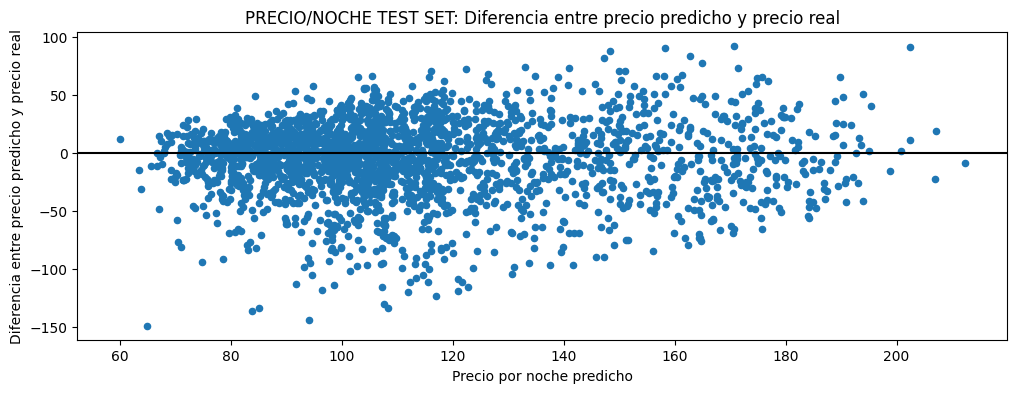

In [312]:
_,ax = plt.subplots(figsize=(12,4))
test_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")
ax.set_title('PRECIO/NOCHE TEST SET: Diferencia entre precio predicho y precio real')
ax.set_xlabel("Precio por noche predicho")
ax.set_ylabel("Diferencia entre precio predicho y precio real")